In [1]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import moscot as mt
import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from genot.models.model import GENOT
#from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
from genot.nets.nets import MLP_vector_field, MLP_marginal
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from scipy.stats import spearmanr
from sklearn import preprocessing as pp

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/py

## Balanced

In [2]:
#adata_balanced = sc.read("/lustre/groups/ml01/workspace/dominik.klein/cellot_data/hvg.h5ad")
adata_balanced = mt.datasets.sciplex()

In [3]:
adata_balanced

AnnData object with n_obs × n_vars = 799317 × 110984
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [4]:
sc.pp.normalize_total(adata_balanced)
sc.pp.log1p(adata_balanced)

In [5]:
#list(adata_balanced.obs["perturbation"].cat.categories)

In [6]:
#subset = ["control", "dacinostat", "givinostat", "belinostat", "hesperadin", "quisinostat_2hcl", 'alvespimycin_hcl', "tanespimycin", "tak_901", "flavopiridol_hcl"]
subset = ["control", "Dacinostat (LAQ824)", "Givinostat (ITF2357)", "Belinostat (PXD101)", "Hesperadin", "Quisinostat (JNJ-26481585) 2HCl", "Alvespimycin (17-DMAG) HCl", "Tanespimycin (17-AAG)", "TAK-901", "Flavopiridol HCl"]

In [7]:
adata_balanced_red = sc.concat(
    [adata_balanced[adata_balanced.obs["perturbation"]=="control"], adata_balanced[adata_balanced.obs["perturbation"]=="Dacinostat (LAQ824)"]],
    join="outer",
    label="perturbation",
    keys=["control", "Dacinostat (LAQ824)"],
)
#adata_balanced_red = adata_balanced[adata_balanced.obs["drug"].isin(["control", "dacinostat"])]

In [8]:
sc.pp.pca(adata_balanced_red)
sc.pp.neighbors(adata_balanced_red)
sc.tl.umap(adata_balanced_red)

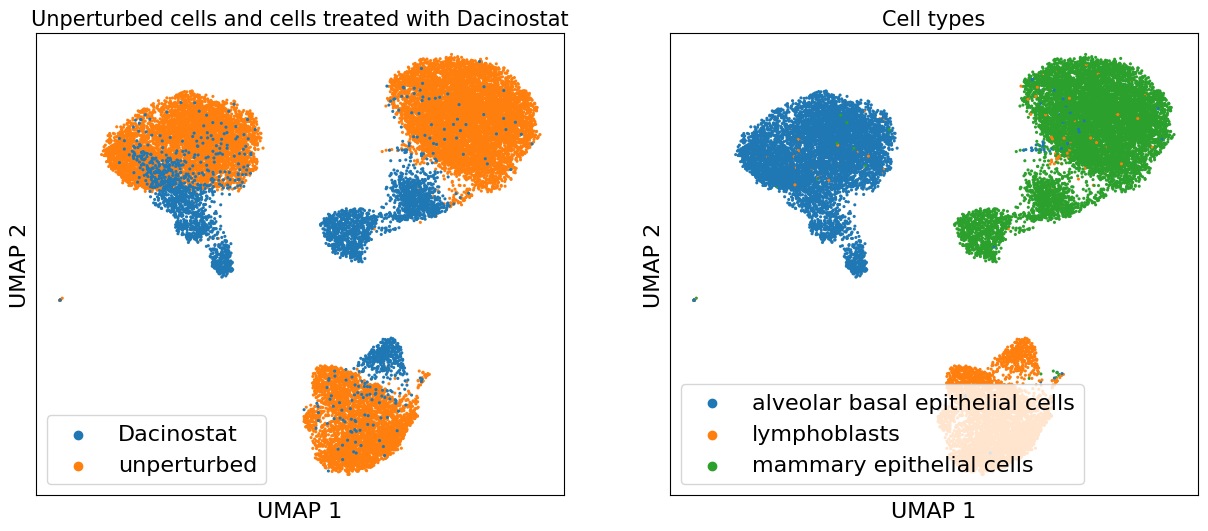

In [9]:
adata_balanced_red.obs["drug_renamed"] = adata_balanced_red.obs.apply(lambda x: "Dacinostat" if x["perturbation"]=="Dacinostat (LAQ824)" else "unperturbed", axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_balanced_red, color=["drug_renamed"], ax=ax1, size=20, show=False)
ax1.set_title(r"Unperturbed cells and cells treated with Dacinostat", fontsize=15)
ax1.set_xlabel("UMAP 1", fontsize=16)
ax1.set_ylabel("UMAP 2", fontsize=16)
ax1.legend(fontsize=16, loc="lower left")
sc.pl.umap(adata_balanced_red, color=["celltype"], ax=ax2, size=20, show=False, vmax="p99")
ax2.set_title(r"Cell types", fontsize=15)
ax2.set_xlabel("UMAP 1", fontsize=16)
ax2.set_ylabel("UMAP 2", fontsize=16)
ax2.legend(fontsize=16, loc="lower left")

In [10]:
source_bl = adata_balanced_red[adata_balanced_red.obs["perturbation"]=="control"].obsm["X_pca"]
target_bl = adata_balanced_red[adata_balanced_red.obs["perturbation"]=="Dacinostat (LAQ824)"].obsm["X_pca"]

In [11]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()
neural_net = MLP_vector_field(target_bl.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)


genot_bl = GENOT(neural_net, ot_solver=ot_solver, epsilon=5e-2, scale_cost="mean", input_dim=50, output_dim=50, iterations=10_000, k_noise_per_x=1)

In [12]:
genot_bl(source_bl, target_bl, 1024, 1024)

I0000 00:00:1732051281.156404 2307978 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3257 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:27:00.0, compute capability: 8.0
100%|██████████| 10000/10000 [05:41<00:00, 29.32it/s]


In [13]:
push_source_bl = [None] * 30

for i in range(30):
    push_source_bl[i] = genot_bl.transport(source_bl, seed=i)[0][0,...]

2024-11-19 22:34:49.771978: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.400941336s
Constant folding an instruction is taking > 1s:

  %dot.45 = f32[17578,256]{1,0} dot(f32[17578,256]{1,0} %constant.502, f32[256,256]{1,0} %constant.503), lhs_contracting_dims={1}, rhs_contracting_dims={0}, metadata={op_name="jit(diffeqsolve)/jit(main)/outer-loop/checkpointed-no-vjp/while/body/checkpointed-no-vjp/while/body/MLP_vector_field/Block_3/fc0/dot_general" source_file="/ictstr01/home/icb/leon.stadelmann/genot_fork/genot/genot/nets/nets.py" source_line=33}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-11-19 22:3

In [14]:
adata_balanced_pushed = adata_balanced_red.copy()
adata_balanced_pushed.obsm["X_pca_result"] = np.concatenate((push_source_bl[0], target_bl), axis=0)
adata_balanced_pushed.obsm["X_pca_result_cond_mean"] = np.concatenate((jnp.mean(jnp.asarray(push_source_bl), axis=0), target_bl), axis=0)

In [15]:
sc.pp.neighbors(adata_balanced_pushed, use_rep="X_pca_result")
sc.tl.umap(adata_balanced_pushed)

In [16]:
from typing import Any, Iterable, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from joblib import Parallel, delayed


def sample_velocities_from_transport_matrix(
    transport_matrix: np.ndarray, target_distribution: np.ndarray, n_samples: int
) -> np.ndarray:
    res = [None] * n_samples
    for i in range(n_samples):
        res[i] = target_distribution[
            jax.vmap(lambda x: jax.random.categorical(jax.random.PRNGKey(i), x))(jnp.log(transport_matrix))
        ]
    return jnp.asarray(res)


def compute_statistics_from_samples(
    samples: np.ndarray, split_to_k_batches: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    batch_size = samples.shape[0] // split_to_k_batches
    assert samples.shape[0] % split_to_k_batches == 0
    # samples is of shape (n_samples, n_cells, dim_velocity_vector)
    df = pd.DataFrame(index=cell_names)

    for i in range(split_to_k_batches):
        df[f"var_{i}"] = np.sum(np.var(samples[i * batch_size : (i + 1) * batch_size, ...], axis=0), axis=1)
        var_cols = [f"var_{i}" for i in range(split_to_k_batches)]

    df["var_of_variance"] = df[var_cols].var(axis=1)
    df["mean_of_variance"] = df[var_cols].mean(axis=1)
    return df


def compute_directional_statistics_from_samples(
    samples: np.ndarray, n_jobs: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    samples = np.asarray(samples)
    n_cells = len(cell_names)
    df = pd.DataFrame(index=cell_names)
    df["directional_variance"] = np.nan
    df["directional_difference"] = np.nan
    df["directional_cosine_sim_variance"] = np.nan
    df["directional_cosine_sim_difference"] = np.nan
    df["directional_cosine_sim_mean"] = np.nan
    results = Parallel(n_jobs=n_jobs, verbose=3)(
        delayed(_directional_statistics_per_cell)(samples[:, cell_index, :]) for cell_index in range(n_cells)
    )
    # cells by samples
    cosine_sims = np.stack([results[i][0] for i in range(n_cells)])
    df.loc[:, "directional_cosine_sim_variance"] = [results[i][1] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_difference"] = [results[i][2] for i in range(n_cells)]
    df.loc[:, "directional_variance"] = [results[i][3] for i in range(n_cells)]
    df.loc[:, "directional_difference"] = [results[i][4] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_mean"] = [results[i][5] for i in range(n_cells)]

    return df, cosine_sims


def _cosine_sim(v1: np.ndarray, v2: np.ndarray) -> np.ndarray:
    """Returns cosine similarity of the vectors."""
    v1_u = _centered_unit_vector(v1)
    v2_u = _centered_unit_vector(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)


def _directional_statistics_per_cell(
    tensor: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Internal function for parallelization.

    Parameters
    ----------
    tensor
        Shape of samples by genes for a given cell.
    """
    n_samples = tensor.shape[0]
    # over samples axis
    mean_velocity_of_cell = tensor.mean(0)
    cosine_sims = [_cosine_sim(tensor[i, :], mean_velocity_of_cell) for i in range(n_samples)]
    angle_samples = [np.arccos(el) for el in cosine_sims]
    return (
        cosine_sims,
        np.var(cosine_sims),
        np.percentile(cosine_sims, 95) - np.percentile(cosine_sims, 5),
        np.var(angle_samples),
        np.percentile(angle_samples, 95) - np.percentile(angle_samples, 5),
        np.mean(cosine_sims),
    )


def _centered_unit_vector(vector: np.ndarray) -> np.ndarray:
    """Returns the centered unit vector of the vector."""
    vector = vector - np.mean(vector)
    return vector / np.linalg.norm(vector)

In [17]:
cosine_vars_train_bl = compute_directional_statistics_from_samples(push_source_bl, 1, adata_balanced_red[adata_balanced_red.obs.perturbation=="control"].obs_names)

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 511 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 1567 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 2047 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 3871 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done 5407 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done 6271 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    9.6s
[Parallel(n_jobs=1)]: Done 8191 tasks      | elapsed:   11.3s
[Parallel(n_j

In [18]:
adata_balanced_red.obs["directional_cosine_sim_variance"] = cosine_vars_train_bl[0]["directional_cosine_sim_variance"]
adata_balanced_pushed.obs["directional_cosine_sim_variance"] = cosine_vars_train_bl[0]["directional_cosine_sim_variance"]

Text(0, 0.5, 'UMAP 2')

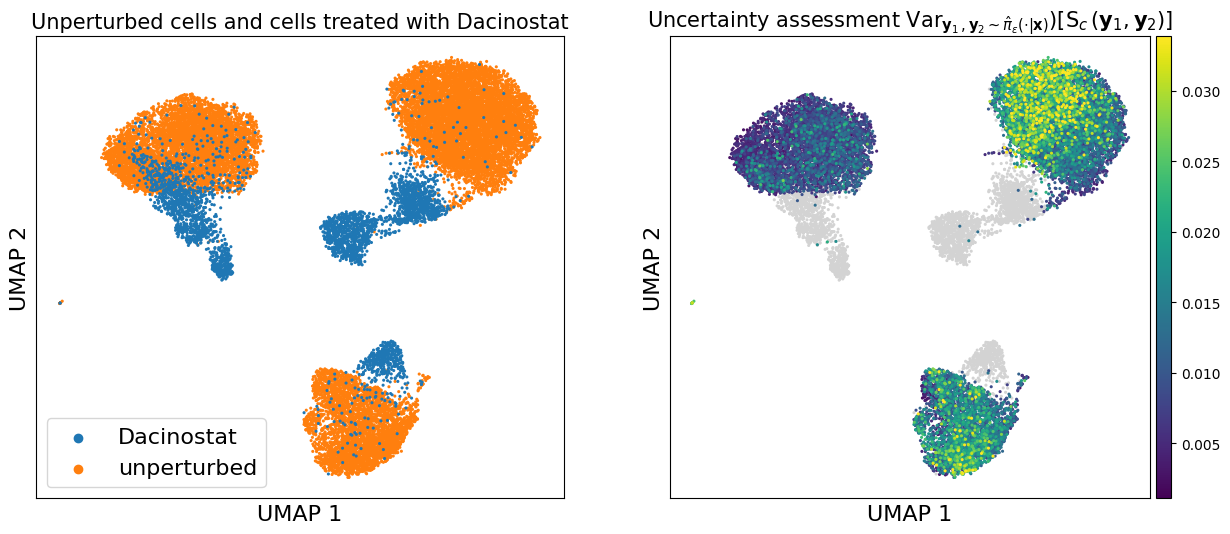

In [19]:
adata_balanced_red.obs["drug_renamed"] = adata_balanced_red.obs.apply(lambda x: "Dacinostat" if x["perturbation"]=="Dacinostat (LAQ824)" else "unperturbed", axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_balanced_red, color=["drug_renamed"], ax=ax1, size=20, show=False)
ax1.set_title(r"Unperturbed cells and cells treated with Dacinostat", fontsize=15)
ax1.set_xlabel("UMAP 1", fontsize=16)
ax1.set_ylabel("UMAP 2", fontsize=16)
ax1.legend(fontsize=16, loc="lower left")
sc.pl.umap(adata_balanced_red, color=["directional_cosine_sim_variance"], ax=ax2, size=20, show=False, vmax="p99")
ax2.set_title(r"Uncertainty assessment $\operatorname{Var}_{\mathbf{y}_1, \mathbf{y}_2 \sim \hat{\pi}_\varepsilon(\cdot | \mathbf{x})})[\operatorname{S}_c(\mathbf{y}_1, \mathbf{y}_2)]$", fontsize=15)
ax2.set_xlabel("UMAP 1", fontsize=16)
ax2.set_ylabel("UMAP 2", fontsize=16)

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


<Axes: title={'center': 'Joint UMAP of transported cells and cells in the target distribution'}, xlabel='UMAP 1', ylabel='UMAP 2'>

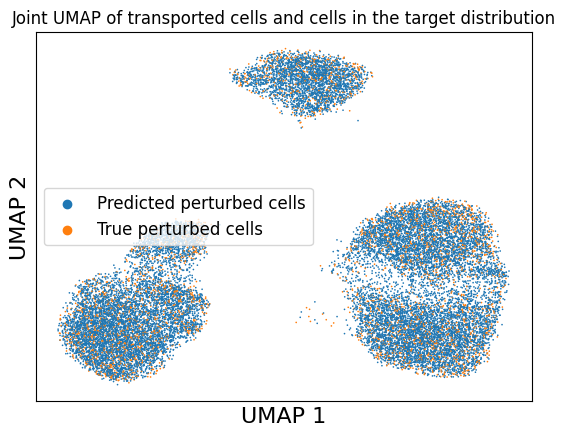

In [21]:
adata_balanced_pushed.obs["col"] = adata_balanced_pushed.obs.apply(lambda x: "Predicted perturbed cells" if x["perturbation"]=="control" else "True perturbed cells", axis=1)
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_balanced_pushed.shape[0])))

fig = sc.pl.umap(adata_balanced_pushed[random_indices,:], color="col", show=False, title="Joint UMAP of transported cells and cells in the target distribution")
fig.set_xlabel("UMAP 1", fontsize=16)
fig.set_ylabel("UMAP 2", fontsize=16)
fig.legend(fontsize=12)
fig

In [22]:
from typing import Tuple, Callable, Union, List, Optional
import scipy.sparse as sp
import jax.numpy as jnp
import jax
import pandas as pd

def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  
        predicted_tgt_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(predicted_tgt_cells), batch_size):
            _, indices = get_knn_fn(predicted_tgt_cells[index : index + batch_size], tgt_cells, k)
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(predicted_tgt_cells) - index)), min(k, len(tgt_cells)))
            )
        ri = jnp.concatenate(row_indices)
        ci = jnp.concatenate(column_indices)
        mat = np.zeros((len(ri), len(tgt_cells)))
        mat[ri,ci] = 1.0
        return mat

def aggregate_transport_matrix(adata_source, adata_target, tmat, aggregation_key = "celltype", forward = True):
    df_source = adata_source.obs[aggregation_key]
    df_target = adata_target.obs[aggregation_key]

    annotations_source = adata_source.obs[aggregation_key].cat.categories
    annotations_target = adata_target.obs[aggregation_key].cat.categories

    tm = pd.DataFrame(
        np.zeros((len(annotations_source), len(annotations_target))),
        index=annotations_source,
        columns=annotations_target,
    )
    
    for annotation_src in annotations_source:
        for annotation_tgt in annotations_target:
            tm.loc[annotation_src, annotation_tgt] = tmat[
                np.ix_((df_source == annotation_src).squeeze(), (df_target == annotation_tgt).squeeze())
            ].sum()
    return tm#.div(tm.sum(axis=int(forward)), axis=int(not forward))

In [23]:
gex_predicted_bl = push_source_bl[0]
target_test_bl = target_bl
adata_balanced_source_test_bl = adata_balanced[adata_balanced.obs["perturbation"]=="control"]
adata_balanced_target_test_bl = adata_balanced[adata_balanced.obs["perturbation"]=="Dacinostat (LAQ824)"]

In [24]:
tm_bl = project_transport_matrix(gex_predicted_bl, target_test_bl)
agg_tm_bl = aggregate_transport_matrix(adata_balanced_source_test_bl, adata_balanced_target_test_bl, tm_bl, aggregation_key="celltype")

In [25]:
agg_tm_bl

,alveolar basal epithelial cells,lymphoblasts,mammary epithelial cells
alveolar basal epithelial cells,5758.0,17.0,82.0
lymphoblasts,792.0,2451.0,692.0
mammary epithelial cells,130.0,39.0,7617.0


In [26]:
(agg_tm_bl.iloc[0,0] + agg_tm_bl.iloc[1,1] + agg_tm_bl.iloc[2,2])/agg_tm_bl.sum().sum()

0.9003299579019228

In [27]:
spearmanr(1-np.diag(agg_tm_bl.div(agg_tm_bl.sum(axis=1))), adata_balanced_red.obs[["directional_cosine_sim_variance", "celltype"]].groupby("celltype").mean().values)

/tmp/ipykernel_2307978/3195375486.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spearmanr(1-np.diag(agg_tm_bl.div(agg_tm_bl.sum(axis=1))), adata_balanced_red.obs[["directional_cosine_sim_variance", "celltype"]].groupby("celltype").mean().values)


SignificanceResult(statistic=0.5, pvalue=0.6666666666666667)

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


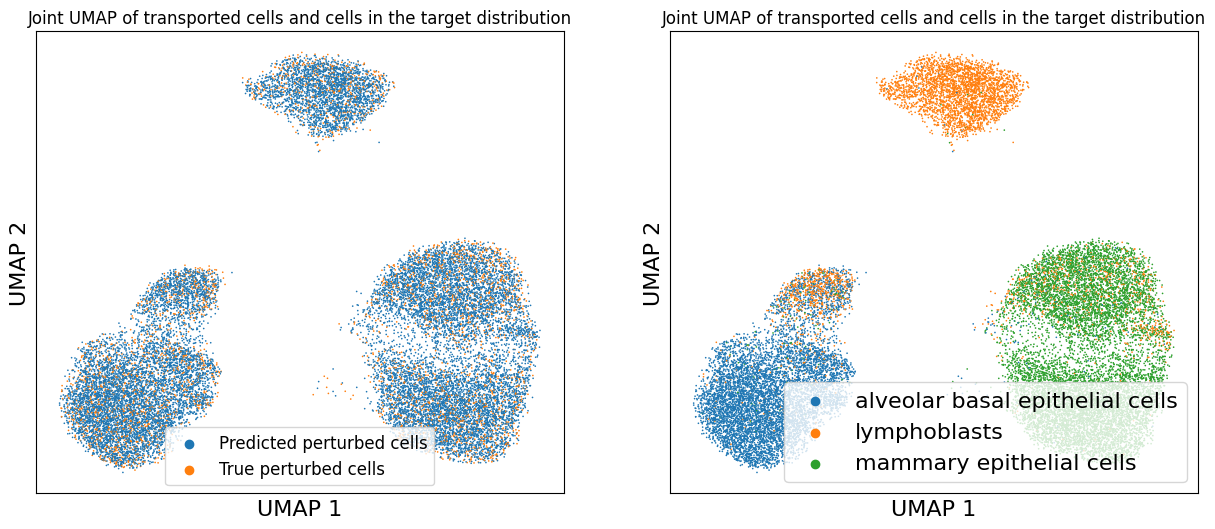

In [28]:
adata_balanced_pushed.obs["col"] = adata_balanced_pushed.obs.apply(lambda x: "Predicted perturbed cells" if x["perturbation"]=="control" else "True perturbed cells", axis=1)
np.random.seed(0)
random_indices_bl=np.random.permutation(list(range(adata_balanced_pushed.shape[0])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_balanced_pushed[random_indices_bl,:], color="col", ax=ax1, show=False, title="Joint UMAP of transported cells and cells in the target distribution")
ax1.set_xlabel("UMAP 1", fontsize=16)
ax1.set_ylabel("UMAP 2", fontsize=16)
sc.pl.umap(adata_balanced_pushed[random_indices_bl,:], color="celltype", ax=ax2, show=False, title="Joint UMAP of transported cells and cells in the target distribution")
ax2.set_xlabel("UMAP 1", fontsize=16)
ax2.set_ylabel("UMAP 2", fontsize=16)
ax1.legend(fontsize=12)
ax2.legend(fontsize=16, loc="lower right")

In [29]:
#adata_balanced_red.write("adata_balanced_red_dacinostat.h5ad")
#adata_balanced_pushed.write("adata_balanced_pushed_dacinostat.h5ad")

## Unbalanced

In [30]:
adata_unbalanced = mt.datasets.sciplex()

In [31]:
sc.pp.normalize_total(adata_unbalanced)
sc.pp.log1p(adata_unbalanced)

In [32]:
adata_unbalanced_red = sc.concat(
    [adata_unbalanced[adata_unbalanced.obs["perturbation"]=="control"], adata_unbalanced[adata_unbalanced.obs["perturbation"]=="Dacinostat (LAQ824)"]],
    join="outer",
    label="drug",
    keys=["control", "Dacinostat (LAQ824)"],
)
adata_unbalanced_red = adata_unbalanced[adata_unbalanced.obs["perturbation"].isin(["control", "Dacinostat (LAQ824)"])]

In [33]:
sc.pp.pca(adata_unbalanced_red)
sc.pp.neighbors(adata_unbalanced_red)
sc.tl.umap(adata_unbalanced_red)

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


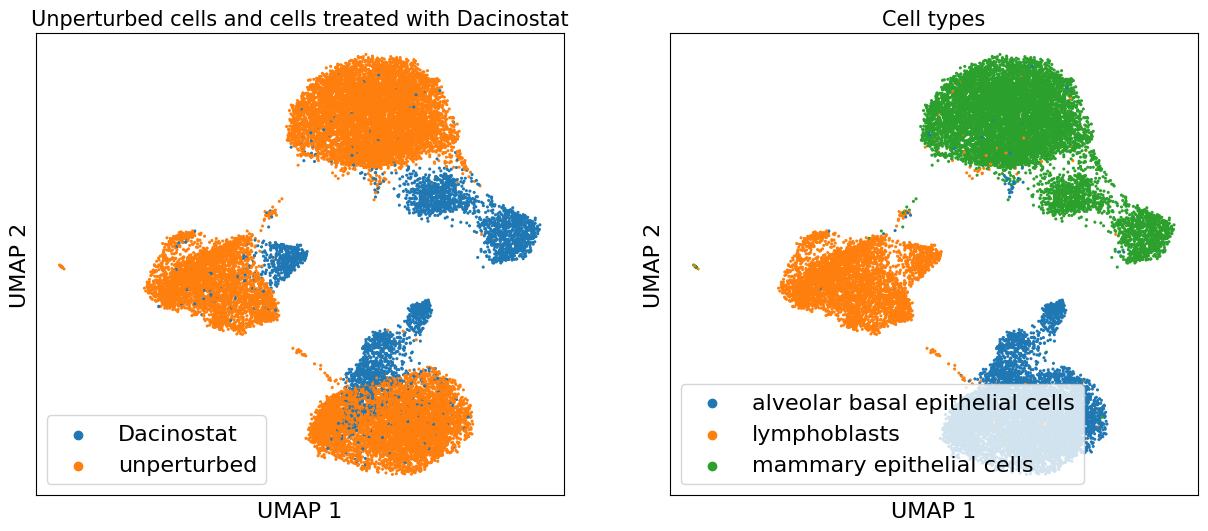

In [34]:
adata_unbalanced_red.obs["drug_renamed"] = adata_unbalanced_red.obs.apply(lambda x: "Dacinostat" if x["perturbation"]=="Dacinostat (LAQ824)" else "unperturbed", axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_unbalanced_red, color=["drug_renamed"], ax=ax1, size=20, show=False)
ax1.set_title(r"Unperturbed cells and cells treated with Dacinostat", fontsize=15)
ax1.set_xlabel("UMAP 1", fontsize=16)
ax1.set_ylabel("UMAP 2", fontsize=16)
ax1.legend(fontsize=16, loc="lower left")
sc.pl.umap(adata_unbalanced_red, color=["celltype"], ax=ax2, size=20, show=False, vmax="p99")
ax2.set_title(r"Cell types", fontsize=15)
ax2.set_xlabel("UMAP 1", fontsize=16)
ax2.set_ylabel("UMAP 2", fontsize=16)
ax2.legend(fontsize=16, loc="lower left")

In [35]:
source_ub = adata_unbalanced_red[adata_unbalanced_red.obs["perturbation"]=="control"].obsm["X_pca"]
target_ub = adata_unbalanced_red[adata_unbalanced_red.obs["perturbation"]=="Dacinostat (LAQ824)"].obsm["X_pca"]

In [36]:
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()
neural_net = MLP_vector_field(target_ub.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)

mlp_eta = MLP_marginal(256, 5)
mlp_xi = MLP_marginal(256, 5)


genot_ub = GENOT(neural_net, mlp_eta=mlp_eta, mlp_xi = mlp_xi, tau_a=0.8, tau_b=0.8, ot_solver=ot_solver, epsilon=5e-2, scale_cost="mean", input_dim=50, output_dim=50, iterations=10_000, k_noise_per_x=1)

In [37]:
genot_ub(source_ub, target_ub, 1024, 1024)

100%|██████████| 10000/10000 [02:58<00:00, 55.99it/s]


In [38]:
push_source_ub = [None] * 30

for i in range(30):
    push_source_ub[i] = genot_ub.transport(source_ub, seed=i)[0][0,...]

In [39]:
adata_unbalanced_pushed = adata_unbalanced_red.copy()
adata_unbalanced_pushed.obsm["X_pca_result"] = np.concatenate((push_source_ub[0], target_ub), axis=0)
adata_unbalanced_pushed.obsm["X_pca_result_cond_mean"] = np.concatenate((jnp.mean(jnp.asarray(push_source_ub), axis=0), target_ub), axis=0)

In [40]:
sc.pp.neighbors(adata_unbalanced_pushed, use_rep="X_pca_result")
sc.tl.umap(adata_unbalanced_pushed)

In [41]:
cosine_vars_train_ub = compute_directional_statistics_from_samples(push_source_ub, 1, adata_unbalanced_red[adata_unbalanced_red.obs.perturbation=="control"].obs_names)

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 511 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 1567 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 2047 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 3871 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done 5407 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done 6271 tasks      | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:   11.2s
[Parallel(n_jobs=1)]: Done 8191 tasks      | elapsed:   12.4s
[Parallel(n_j

In [42]:
adata_unbalanced_red.obs["directional_cosine_sim_variance"] = cosine_vars_train_ub[0]["directional_cosine_sim_variance"]
adata_unbalanced_pushed.obs["directional_cosine_sim_variance"] = cosine_vars_train_ub[0]["directional_cosine_sim_variance"]

Text(0, 0.5, 'UMAP 2')

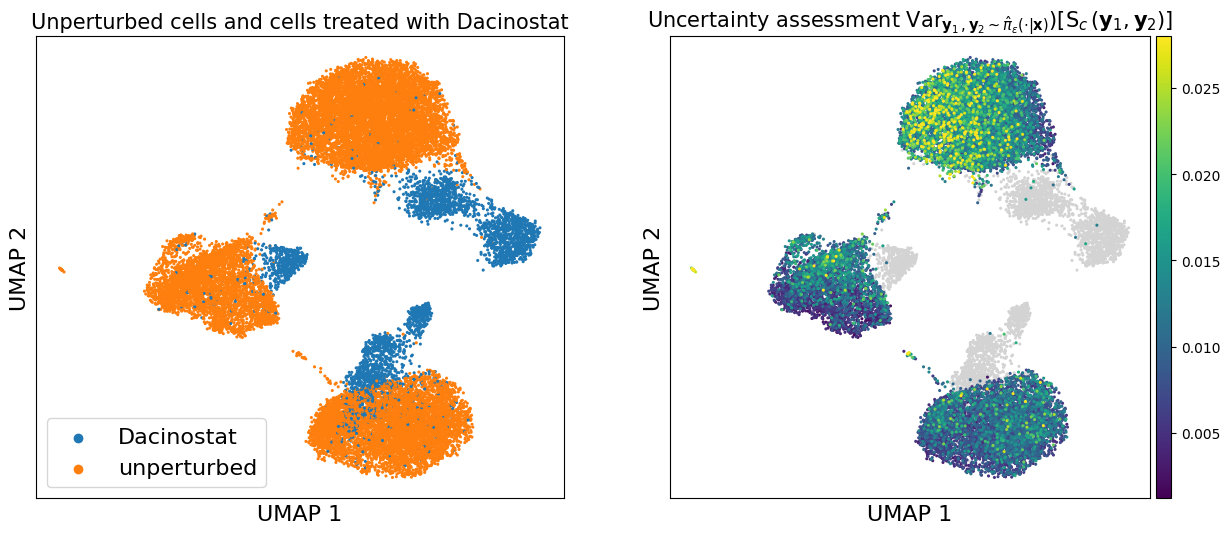

In [43]:
adata_unbalanced_red.obs["drug_renamed"] = adata_unbalanced_red.obs.apply(lambda x: "Dacinostat" if x["perturbation"]=="Dacinostat (LAQ824)" else "unperturbed", axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_unbalanced_red, color=["drug_renamed"], ax=ax1, size=20, show=False)
ax1.set_title(r"Unperturbed cells and cells treated with Dacinostat", fontsize=15)
ax1.set_xlabel("UMAP 1", fontsize=16)
ax1.set_ylabel("UMAP 2", fontsize=16)
ax1.legend(fontsize=16, loc="lower left")
sc.pl.umap(adata_unbalanced_red, color=["directional_cosine_sim_variance"], ax=ax2, size=20, show=False, vmax="p99")
ax2.set_title(r"Uncertainty assessment $\operatorname{Var}_{\mathbf{y}_1, \mathbf{y}_2 \sim \hat{\pi}_\varepsilon(\cdot | \mathbf{x})})[\operatorname{S}_c(\mathbf{y}_1, \mathbf{y}_2)]$", fontsize=15)
ax2.set_xlabel("UMAP 1", fontsize=16)
ax2.set_ylabel("UMAP 2", fontsize=16)

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


<Axes: title={'center': 'Joint UMAP of transported cells and cells in the target distribution'}, xlabel='UMAP 1', ylabel='UMAP 2'>

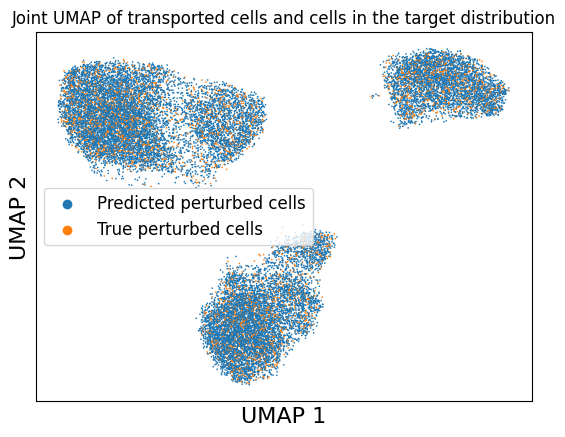

In [44]:
adata_unbalanced_pushed.obs["col"] = adata_unbalanced_pushed.obs.apply(lambda x: "Predicted perturbed cells" if x["perturbation"]=="control" else "True perturbed cells", axis=1)
np.random.seed(0)
random_indices_ub=np.random.permutation(list(range(adata_unbalanced_pushed.shape[0])))

fig = sc.pl.umap(adata_unbalanced_pushed[random_indices_ub,:], color="col", show=False, title="Joint UMAP of transported cells and cells in the target distribution")
fig.set_xlabel("UMAP 1", fontsize=16)
fig.set_ylabel("UMAP 2", fontsize=16)
fig.legend(fontsize=12)
fig

In [45]:
gex_predicted_ub = push_source_ub[0]
target_test_ub = target_ub
adata_unbalanced_source_test_ub = adata_unbalanced[adata_unbalanced.obs["perturbation"]=="control"]
adata_unbalanced_target_test_ub = adata_unbalanced[adata_unbalanced.obs["perturbation"]=="Dacinostat (LAQ824)"]

In [46]:
tm_ub = project_transport_matrix(gex_predicted_ub, target_test_ub)
agg_tm_ub = aggregate_transport_matrix(adata_unbalanced_source_test_ub, adata_unbalanced_target_test_ub, tm_ub, aggregation_key="celltype")

In [47]:
agg_tm_ub

,alveolar basal epithelial cells,lymphoblasts,mammary epithelial cells
alveolar basal epithelial cells,5722.0,52.0,83.0
lymphoblasts,193.0,3568.0,174.0
mammary epithelial cells,95.0,118.0,7573.0


In [48]:
(agg_tm_ub.iloc[0,0] + agg_tm_ub.iloc[1,1] + agg_tm_ub.iloc[2,2])/agg_tm_ub.sum().sum()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


0.9593241551939925

In [49]:
spearmanr(1-np.diag(agg_tm_ub.div(agg_tm_ub.sum(axis=1))), adata_unbalanced_red.obs[["directional_cosine_sim_variance", "celltype"]].groupby("celltype").mean().values)

/tmp/ipykernel_2307978/3055403395.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spearmanr(1-np.diag(agg_tm_ub.div(agg_tm_ub.sum(axis=1))), adata_unbalanced_red.obs[["directional_cosine_sim_variance", "celltype"]].groupby("celltype").mean().values)


SignificanceResult(statistic=-0.5, pvalue=0.6666666666666667)

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


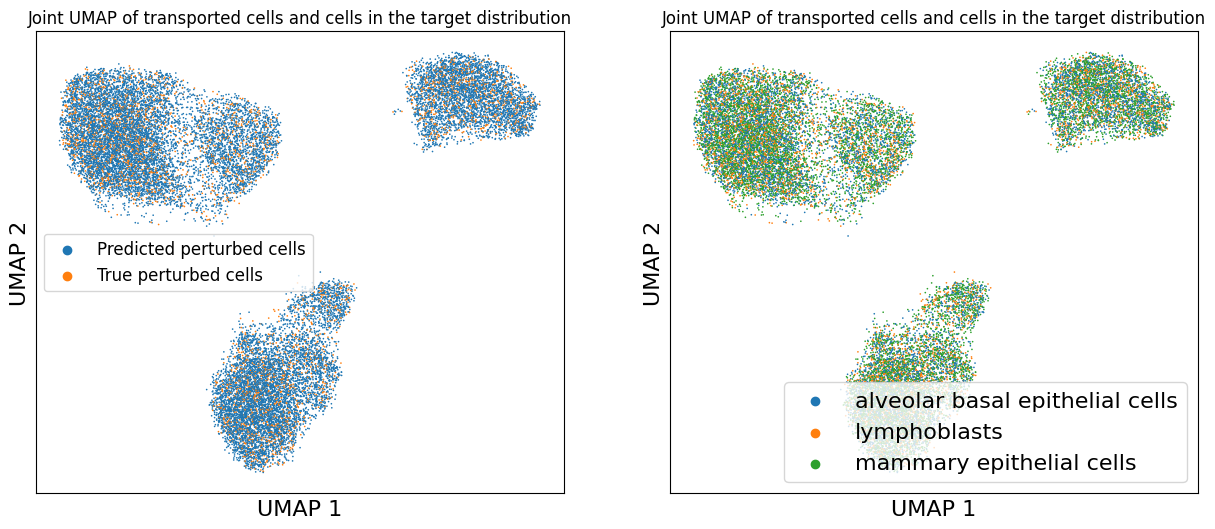

In [50]:
adata_unbalanced_pushed.obs["col"] = adata_unbalanced_pushed.obs.apply(lambda x: "Predicted perturbed cells" if x["perturbation"]=="control" else "True perturbed cells", axis=1)
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_unbalanced_pushed.shape[0])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_unbalanced_pushed[random_indices_ub,:], color="col", ax=ax1, show=False, title="Joint UMAP of transported cells and cells in the target distribution")
ax1.set_xlabel("UMAP 1", fontsize=16)
ax1.set_ylabel("UMAP 2", fontsize=16)
sc.pl.umap(adata_unbalanced_pushed[random_indices_ub,:], color="celltype", ax=ax2, show=False, title="Joint UMAP of transported cells and cells in the target distribution")
ax2.set_xlabel("UMAP 1", fontsize=16)
ax2.set_ylabel("UMAP 2", fontsize=16)
ax1.legend(fontsize=12)
ax2.legend(fontsize=16, loc="lower right")